In [1]:
!pwd

/export/home/orenkobo


In [20]:
import scipy
def draw_stars_box(regr_acc_l, rand_acc_l, stat_test = 'wilcoxon', suf="",show=True, ax=None, reverse_labels = False, alternative='two-sided',
                   verbose = True, ylabel = "CORRELATION", title = "",xlabels = ['Actual','Shuffled']):
    def stars(p):
        if p < 0.0001:
            return "****"
        elif (p < 0.001):
            return "***"
        elif (p < 0.01):
            return "**"
        elif (p < 0.05):
            return "*"
        else:
            return "-"
    print("Hwwlp")
    #https://github.com/jbmouret/matplotlib_for_papers
    if stat_test == 'wilcoxon':
        z, p = scipy.stats.wilcoxon(regr_acc_l, rand_acc_l, alternative=alternative)
    if stat_test == 'mannwhittney':
        z, p = scipy.stats.mannwhitneyu(regr_acc_l, rand_acc_l, alternative=alternative)
    p_value = p * 2
    stars_txt = stars(p)
    s = f"{suf} : {stat_test}: z = {z} , p = {p} "
    if verbose:
        print(s)

    fig = figure(figsize=(3,3))
    if ax is None:
        ax = fig.add_subplot(111)

    bp = ax.boxplot([regr_acc_l, rand_acc_l])
    params = {
        'axes.labelsize': 8,
        'font.size': 8,
        'legend.fontsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'text.usetex': False,
        'figure.figsize': [5, 8]
    }
    rcParams.update(params)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x', direction='out', size=15)
    ax.tick_params(axis='y', length=0)
    ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    # colors, as before
    colors = Set2_7.mpl_colors

    for i in range(0, len(bp['boxes'])):
        bp['boxes'][i].set_color(colors[i])
        # we have two whiskers!
        bp['whiskers'][i*2].set_color(colors[i])
        bp['whiskers'][i*2 + 1].set_color(colors[i])
        bp['whiskers'][i*2].set_linewidth(2)
        bp['whiskers'][i*2 + 1].set_linewidth(2)
        # fliers
        # (set allows us to set many parameters at once)
        bp['fliers'][i].set(markerfacecolor=colors[i],
                            marker='o', alpha=0.75, markersize=6,
                            markeredgecolor='none')
        bp['medians'][i].set_color('black')
        bp['medians'][i].set_linewidth(3)
        # and 4 caps to remove
        for c in bp['caps']:
            c.set_linewidth(0)
    for i in range(len(bp['boxes'])):
        box = bp['boxes'][i]
        box.set_linewidth(0)
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
            boxCoords = list(zip(boxX,boxY))
            boxPolygon = Polygon(boxCoords, facecolor = colors[i], linewidth=0)
            ax.add_patch(boxPolygon)

    if reverse_labels:
        xlabels.reverse()
    ax.set_xticklabels(xlabels, fontsize=15)


    y_max = np.max(np.concatenate((regr_acc_l, rand_acc_l)))
    y_min = np.min(np.concatenate((regr_acc_l, rand_acc_l)))

    ax.annotate("", xy=(1, y_max), xycoords='data',
                xytext=(2, y_max), textcoords='data',
                arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                                connectionstyle="bar,fraction=0.2"))
    ax.text(1.5, y_max + abs(y_max - y_min)*0.2, stars_txt,
            horizontalalignment='center',
            verticalalignment='center')
    # ax.set_suptitle(f"Per iteration accuracy {suf} - {p}", fontsize = 12)
    # ax.subplots_adjust(left=0.2)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title)
    if show:
        plt.show()


    return s, ax


In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import datetime
print(datetime.datetime.now())


2022-06-29 12:38:15.224564


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.keras import backend as K
print(K._get_available_gpus())

Num GPUs Available:  1
['/device:GPU:0']


In [5]:
import joblib

import tensorflow as tf
import numpy as np
import datetime
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
scale_col = "x_gaze_location_standard_scaled"

def apply_phq_cutoff(df , neg_phq_cutoff, pos_phq_cutoff):
    df["phq_binary_label"] = [0.0 if x <= neg_phq_cutoff else 1.0 if x >= pos_phq_cutoff else "other" for x in df.phq_score]
    df = df[df.phq_binary_label!= 'other']
    return df


def get_timecols_df_for_DL(fn ="/Users/orenkobo/Desktop/PhD_new/repos/HebLingStudy/notebooks/df.csv",
                           scale_col = scale_col):

    import string, re
    print(f"{datetime.datetime.now()} Reading csv from {fn}")
    df = pd.read_csv(fn,
                     index_col=None,
                     converters={#'alephbert_enc': eval,
                         scale_col : eval,
                         # 'x_gaze_location_minmax_scaled' : eval,
                         # 'x_gaze_location_standard_scaled' : eval,
                         # 'target_word_x_range' : eval
                         # 'phq_label': bool
                     })
    print(df.shape)


    df = df[df.Sentence_type != 'F'].reset_index(drop=True)


    id_cols = ["phq_score","phq_group","Subject", "Sentence_type",
               "sentence_pupil_diameter_mean","set_num"]
    # vec_size = 3500
    # new_colname = f"x_gaze_location_{vec_size}"
    cols = [f"timepoint#{i}" for i in range(875)]
    # df[new_colname] = df["x_gaze_location_standard_scaled"].apply(lambda x : x[:vec_size])
    timeseries_df = pd.DataFrame(data = df[scale_col].to_list() , columns = cols)
    timeseries_df[id_cols] = df[id_cols]
    timeseries_df = timeseries_df.iloc[:,200:]
    cols = [x for x in timeseries_df.columns if "timepoint" in x]
    return timeseries_df, cols

In [6]:
import pandas as pd
d = {}
df_fn = "/export/home/orenkobo/Aim1/paper_analysis/Artifacts/df_new_full__unsegmented_alldata_new_FINAL_paparanalysis.csv"
# df_fn = "/Users/orenkobo/Desktop/PhD/HebLingStudy/ts_data/Artifacts2/df_new_full__unsegmented_alldata_new_FINAL.csv"
# et_scale_col = "x_gaze_location_rescaled"
et_scale_col = "x_gaze_location_standard_scaled"
override_cutoff = [7,8]
df, timepoint_cols = get_timecols_df_for_DL(fn =df_fn, scale_col = scale_col)
df = apply_phq_cutoff(df,
                      neg_phq_cutoff = override_cutoff[0],
                      pos_phq_cutoff = override_cutoff[1])


cond_df = pd.get_dummies(df['Sentence_type'])
cond_cols = cond_df.columns.tolist()
df = pd.concat([df, cond_df],axis=1)
df = df.reset_index(drop=True)
df['encoded_cond'] = LabelEncoder().fit_transform(df['Sentence_type'])

df

2022-06-29 12:38:20.509334 Reading csv from /export/home/orenkobo/Aim1/paper_analysis/Artifacts/df_new_full__unsegmented_alldata_new_FINAL_paparanalysis.csv
(9696, 32)


,timepoint#200,timepoint#201,timepoint#202,timepoint#203,timepoint#204,timepoint#205,timepoint#206,timepoint#207,timepoint#208,timepoint#209,...,Subject,Sentence_type,sentence_pupil_diameter_mean,set_num,phq_binary_label,A,B,C,D,encoded_cond
0,1.248853,1.242846,1.250856,1.257864,1.246851,1.239843,1.238841,1.250856,1.242846,1.239843,...,3,A,5110.630668,17,0.0,1,0,0,0,0
1,-0.605603,-0.604602,-0.602600,-0.590588,-1.061065,-1.648661,-1.700713,-1.695708,-1.703717,-1.710724,...,3,B,4974.146741,5,0.0,0,1,0,0,1
2,0.127316,0.133326,0.121306,0.099268,0.104277,0.115296,0.122307,0.124311,0.135330,0.161374,...,3,D,4739.278462,12,0.0,0,0,0,1,3
3,-1.144312,-1.155340,-1.149325,-1.117245,-1.106217,-1.129275,-1.135290,-1.111230,-1.109224,-1.127270,...,3,A,4775.260020,6,0.0,1,0,0,0,0
4,-1.554332,-1.571359,-1.577369,-1.608418,-1.600405,-1.571359,-1.558338,-1.560341,-1.565349,-1.573362,...,3,B,4746.720839,26,0.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,-1.686416,-1.706449,-1.697434,-2.352531,-2.500779,-2.447690,-2.421646,-2.419643,-2.425653,-2.450695,...,139,D,5117.994088,0,1.0,0,0,0,1,3
3228,0.985337,0.997349,0.986338,0.976329,0.983335,0.991343,0.990342,0.994346,0.975328,0.977330,...,139,D,4995.187626,15,1.0,0,0,0,1,3
3229,1.002969,1.014985,0.504330,0.345126,0.339118,0.340120,0.351134,0.363149,0.364150,0.377167,...,139,A,4934.199434,27,1.0,1,0,0,0,0
3230,1.745621,1.753631,1.758638,1.737610,1.736609,1.735608,1.736609,1.741616,1.322060,1.367120,...,139,C,5056.427875,4,1.0,0,0,1,0,2


In [7]:
print(df[timepoint_cols].shape)
print(df[timepoint_cols].dropna().shape)
df[timepoint_cols] = df[timepoint_cols].ffill()
print(df[timepoint_cols].shape)

(3232, 675)
(1427, 675)
(3232, 675)


In [8]:
def generate_3d_ds(df, feats = timepoint_cols):
    data_3d = []

    labels = []
    # print(f"{datetime.datetime.now()} - DS generated Start")
    for idx , row in df.iterrows():
        # if (idx % 500) == 0:
        #     print(idx)
        l = []
        for col in feats:
            l.append([row[col]] + [row['encoded_cond']])
        data_3d.append(l)
        labels.append(row["phq_binary_label"])
    X_input = np.asarray(data_3d)
    X_input_reshaped = np.swapaxes(X_input,1,2)
    # print(f"{datetime.datetime.now()} - DS generated Done")

    return X_input_reshaped, labels


In [9]:
def calc_per_subj_pred(pred, n=32):
    if type(pred) != list:
        pred = [x[0] for x in pred]
    c = [pred[i * n:(i + 1) * n] for i in range((len(pred) + n - 1) // n )]
    l = pd.DataFrame(c).mean(axis=1)
    return l

In [10]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=16, restore_best_weights=True)]

def train_fold(X_train, y_train, X_val, y_val, voc_size=4, nepochs=20):

    inp1 = layers.Input(shape=(1, 675))  # TensorShape([None, 2, 100])
    inp2 = layers.Input(shape=(1, 675))  # TensorShape([None, 1, 100])
    x2 = layers.Embedding(input_dim=voc_size, output_dim=8)(inp2)  # TensorShape([None, 1, 100, 8])
    x2_reshaped = tf.transpose(tf.squeeze(x2, axis=1), [0, 2, 1])  # TensorShape([None, 8, 100])
    x = layers.concatenate([inp1, x2_reshaped], axis=1)
    x = layers.LSTM(32, activation='tanh',
                    # kernel_regularizer=tf.keras.regularizers.l1(0.001),
                    activity_regularizer=tf.keras.regularizers.l1(0.01)
                    )(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(8, activation='tanh',
                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                    activity_regularizer=tf.keras.regularizers.l2(0.01)
                    )(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp1, inp2], outputs=[x])

    # print("A1 : ", datetime.datetime.now())
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['acc']
    )

    train_inp_gaze = X_train[:, :1, :]
    train_inp_cond = X_train[:, 1:, :]
    val_inp_gaze = X_val[:, :1, :]
    val_inp_cond = X_val[:, 1:, :]



    his = model.fit(epochs=nepochs, verbose=0,
              x=[train_inp_gaze, train_inp_cond], y=np.array(y_train).astype('float'),
              validation_data = ([val_inp_gaze, val_inp_cond], np.array(y_val).astype('float')),
                    callbacks = callbacks)
    return model


In [11]:
import numpy as np
from sklearn.model_selection import LeavePGroupsOut, GroupShuffleSplit
groups1 = df['Subject']
# lpgo1 = LeavePGroupsOut(n_groups=10)
res_dict = {}
i = 0
d = []

import random
from numpy.random import seed
seed(1)
tf.random.set_seed(3)
# from tensorflow.keras.utils import set_random_seed
# set_random_seed(2)
c = 0
# num_iters = 2
for to_shuffle in [False, True]:
    res_dict_key = 'shuffled_iter' if to_shuffle else 'normal_iter'
    res_dict[res_dict_key] = {}
    for ne in [15]:#:,30,50,100]:
        # if 1==1:
        for num_iters in [500]:#,200]:#310,15,20,25,30,50,100]:
            for n_test_subjs in [20]:# [4,8,12,15,20]:
                # num_iters = 15
                # n_test_subjs = 8
                c+=1
                lpgo1 = GroupShuffleSplit(n_splits=num_iters, test_size=n_test_subjs, random_state = 7)
                print(f"{datetime.datetime.now()} : Start - c = {c} ({ne, num_iters, n_test_subjs, to_shuffle}")
                i = 0
                for tmp_index, test_index in lpgo1.split(X = df[timepoint_cols] , y = df['phq_binary_label'], groups = groups1):
                    print(f"{datetime.datetime.now()}: Iter {i} (c={c})")
                    if i==num_iters:
                        break
                    res_dict[res_dict_key][i] = {}
                    res_dict[res_dict_key][i]["nepochs"] = ne
                    res_dict[res_dict_key][i]["num_iters"] = num_iters
                    res_dict[res_dict_key][i]["n_test_subjs"] = n_test_subjs
                    res_dict[res_dict_key][i]["is_shuffle_iter"] = to_shuffle
                    # lpgo2 = LeavePGroupsOut(n_groups=10)
                    lpgo2 = GroupShuffleSplit(n_splits=num_iters, test_size=n_test_subjs, random_state = 7)
                    test_subjects = list(np.unique(groups1.iloc[test_index]))
                    test_df = df.iloc[test_index]
                    tmp_df = df.iloc[tmp_index]
                    groups2 = tmp_df['Subject']
                    for train_index, val_index in lpgo2.split(X = tmp_df[timepoint_cols] ,
                                                              y = tmp_df['phq_binary_label'],
                                                              groups = groups2):
                        train_subjects = list(np.unique(groups2.iloc[train_index]))
                        val_subjects = list(np.unique(groups2.iloc[val_index]))
                        train_df = tmp_df.iloc[train_index]
                        val_df = tmp_df.iloc[val_index]
                        break
                    X_train, y_train = generate_3d_ds(train_df)
                    X_test, y_test = generate_3d_ds(test_df)
                    X_val, y_val = generate_3d_ds(val_df)
                    if to_shuffle:
                        y_train = random.sample(y_train, len(y_train))
                        y_test = random.sample(y_test, len(y_test))
                        y_val = random.sample(y_val, len(y_val))
                    # print(X_train.shape, X_test.shape, X_val.shape)
                    # print(f"{datetime.datetime.now()}: {len(test_subjects)} Test subject : {test_subjects}")
                    # print(f"{datetime.datetime.now()}: {len(val_subjects)} Val subject : {val_subjects}")
                    # print(f"{datetime.datetime.now()}: {len(train_subjects)} Train subject : {train_subjects}")
                    # print(f"{datetime.datetime.now(): Train Fold #{i}}")
                    fold_model = train_fold(X_train, y_train, X_val, y_val , nepochs=ne)
                    fold_eval = fold_model.evaluate([X_test[:, :1, :], X_test[:, 1:, :]], np.array(y_test).astype('float'))
                    fold_test_pred = fold_model.predict([X_test[:, :1, :], X_test[:, 1:, :]])
                    # print("Test eval is " , fold_eval)
                    # res_dict[i]["his"] = fold_his
                    # res_dict[i]["trained_model"] = fold_model
                    res_dict[res_dict_key][i]["eval"] = fold_eval[1]
                    res_dict[res_dict_key][i]["test_subjects"] = test_subjects
                    res_dict[res_dict_key][i]["test_pred"] = [x[0] for x in fold_test_pred]
                    # print("Shape of pred is " , fold_test_pred.shape)
                    res_dict[res_dict_key][i]["per_subject_mean_pred"] = calc_per_subj_pred(fold_test_pred)
                    # print("Shape of per_subject_mean_pred" , res_dict[i]["per_subject_mean_pred"].shape)
                    # break
                    res_dict[res_dict_key][i]["per_subject_mean_label"] = calc_per_subj_pred(y_test)
                    res_dict[res_dict_key][i]["per_subject_is_success"] = [True if round(p)==round(t) else False for p,t in
                                                             zip(res_dict[res_dict_key][i]["per_subject_mean_pred"],
                                                                 res_dict[res_dict_key][i]["per_subject_mean_label"])]
                    res_dict[res_dict_key][i]["subj_level_acc"] = sum(res_dict[res_dict_key][i]["per_subject_is_success"]) / \
                                                                  len(res_dict[res_dict_key][i]["per_subject_is_success"])
                    # print(f"{datetime.datetime.now()}: Finished Train Fold #{i} - thus far subj acc is "
                    #       f"{np.mean([res_dict[x]['subj_level_acc'] for x in range(i)])} and regular acc is"
                    #       f"{np.mean([res_dict[x]['eval'] for x in range(i)])}")
                    i+=1

                conf_acc_1 = np.mean([res_dict[res_dict_key][x]['eval'] for x in range(num_iters)])
                conf_acc_2 = np.mean([res_dict[res_dict_key][x]['subj_level_acc'] for x in range(num_iters)])
                print(f"{datetime.datetime.now()} - c = {c} ({ne, num_iters, n_test_subjs, to_shuffle}) , accs are {conf_acc_1}, {conf_acc_2}")
                # if conf_acc_2 > 0.55 or conf_acc_2 < 0.45:
                #     print("!!!!!!!!!!!!!!!!!!!!!!!!!" , c)
                d.append([num_iters, ne, n_test_subjs, conf_acc_1, conf_acc_2, to_shuffle])
                print(d)
                print(pd.DataFrame(d))
print(f"{datetime.datetime.now()} Done")
res_df5 = pd.DataFrame(d , columns=["num_iters","num_epochs","num_test_subjs","eval","subj_acc","is_shuffle_iter"])
joblib.dump(res_df5, "./res_df_with_both_shuffle__freeze__fixed.jbl")
joblib.dump(res_dict, "./res_dict_with_both_shuffle__freeze__fixed.jbl")



2022-06-29 12:38:48.039708 : Start - c = 1 ((15, 500, 20, False)
2022-06-29 12:38:48.046434: Iter 0 (c=1)
20/20 [==============================] - 0s 3ms/step - loss: 1.3225 - acc: 0.6203
2022-06-29 12:39:13.369934: Iter 1 (c=1)
20/20 [==============================] - 0s 3ms/step - loss: 1.4805 - acc: 0.5516
2022-06-29 12:39:37.616618: Iter 2 (c=1)
20/20 [==============================] - 0s 3ms/step - loss: 1.5817 - acc: 0.5375
2022-06-29 12:40:01.833063: Iter 3 (c=1)
20/20 [==============================] - 0s 3ms/step - loss: 1.2164 - acc: 0.5984
2022-06-29 12:40:26.199731: Iter 4 (c=1)
20/20 [==============================] - 0s 3ms/step - loss: 1.2816 - acc: 0.6125
2022-06-29 12:40:50.513296: Iter 5 (c=1)
20/20 [==============================] - 0s 3ms/step - loss: 1.4813 - acc: 0.5437
2022-06-29 12:41:14.941597: Iter 6 (c=1)
20/20 [==============================] - 0s 3ms/step - loss: 1.3544 - acc: 0.5875
2022-06-29 12:41:39.286110: Iter 7 (c=1)
20/20 [==========================

['./res_dict_with_both_shuffle__freeze__fixed.jbl']

In [14]:
print(res_dict.keys())


dict_keys(['normal_iter', 'shuffled_iter'])


In [13]:

res_dict = joblib.load('./res_dict_with_both_shuffle__freeze__fixed.jbl')

In [23]:
shuffled_dist = [res_dict['shuffled_iter'][x]['subj_level_acc'] for x in range(num_iters)]
actual_dist = [res_dict['normal_iter'][x]['subj_level_acc'] for x in range(num_iters)]
actual_corr = np.mean(actual_dist)
print(len([x for x in shuffled_dist if x > actual_corr]))
print(len(shuffled_dist))

58
500


Text(0.5, 0, 'Accuracy')

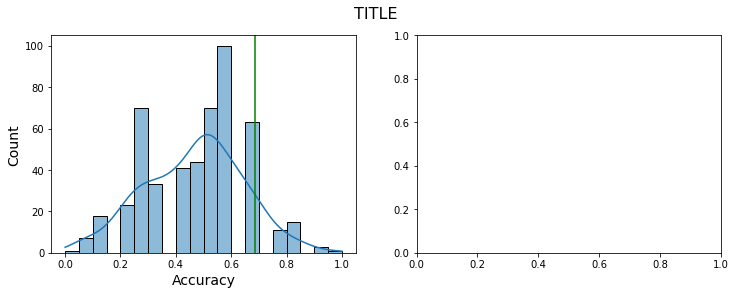

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle(f"TITLE", fontsize=16)
sns.histplot(shuffled_dist, kde=True, bins=20, ax = axs[0])
axs[0].axvline(x=actual_corr, color='green')
axs[0].set_ylabel(ylabel="Count", fontsize=14)
axs[0].set_xlabel(xlabel="Accuracy", fontsize=14)

In [24]:
draw_stars_box(actual_dist, shuffled_dist, "wilcoxon" , ax=axs[1])

Hwwlp
 : wilcoxon: z = 6143.0 , p = 1.9495969812089653e-63 


NameError: name 'figure' is not defined

In [11]:
import numpy as np
from sklearn.model_selection import LeavePGroupsOut, GroupShuffleSplit
groups1 = df['Subject']
# lpgo1 = LeavePGroupsOut(n_groups=10)
res_dict = {}
i = 0
d = []

import random
from numpy.random import seed
seed(1)
tf.random.set_seed(3)
# from tensorflow.keras.utils import set_random_seed
# set_random_seed(2)
c = 0
# num_iters = 2
for to_shuffle in [False]:
    for ne in [10,20]:#:,30,50,100]:
        # if 1==1:
        for num_iters in [100, 500]:#,200]:#310,15,20,25,30,50,100]:
            for n_test_subjs in [10, 20]:# [4,8,12,15,20]:
                # num_iters = 15
                # n_test_subjs = 8
                c+=1
                lpgo1 = GroupShuffleSplit(n_splits=num_iters, test_size=n_test_subjs, random_state = 7)
                print(f"{datetime.datetime.now()} : Start - c = {c} ({ne, num_iters, n_test_subjs, to_shuffle}")
                i = 0
                for tmp_index, test_index in lpgo1.split(X = df[timepoint_cols] , y = df['phq_binary_label'], groups = groups1):
                    print(f"{datetime.datetime.now()}: Iter {i}")
                    if i==num_iters:
                        break
                    res_dict[i] = {}
                    # lpgo2 = LeavePGroupsOut(n_groups=10)
                    lpgo2 = GroupShuffleSplit(n_splits=num_iters, test_size=n_test_subjs, random_state = 7)
                    test_subjects = list(np.unique(groups1.iloc[test_index]))
                    test_df = df.iloc[test_index]
                    tmp_df = df.iloc[tmp_index]
                    groups2 = tmp_df['Subject']
                    for train_index, val_index in lpgo2.split(X = tmp_df[timepoint_cols] ,
                                                              y = tmp_df['phq_binary_label'],
                                                              groups = groups2):
                        train_subjects = list(np.unique(groups2.iloc[train_index]))
                        val_subjects = list(np.unique(groups2.iloc[val_index]))
                        train_df = tmp_df.iloc[train_index]
                        val_df = tmp_df.iloc[val_index]
                        break
                    X_train, y_train = generate_3d_ds(train_df)
                    X_test, y_test = generate_3d_ds(test_df)
                    X_val, y_val = generate_3d_ds(val_df)
                    if to_shuffle:
                        y_train = random.sample(y_train, len(y_train))
                        y_test = random.sample(y_test, len(y_test))
                        y_val = random.sample(y_val, len(y_val))
                    # print(X_train.shape, X_test.shape, X_val.shape)
                    # print(f"{datetime.datetime.now()}: {len(test_subjects)} Test subject : {test_subjects}")
                    # print(f"{datetime.datetime.now()}: {len(val_subjects)} Val subject : {val_subjects}")
                    # print(f"{datetime.datetime.now()}: {len(train_subjects)} Train subject : {train_subjects}")
                    # print(f"{datetime.datetime.now(): Train Fold #{i}}")
                    fold_model = train_fold(X_train, y_train, X_val, y_val , nepochs=ne)
                    fold_eval = fold_model.evaluate([X_test[:, :1, :], X_test[:, 1:, :]], np.array(y_test).astype('float'))
                    fold_test_pred = fold_model.predict([X_test[:, :1, :], X_test[:, 1:, :]])
                    # print("Test eval is " , fold_eval)
                    # res_dict[i]["his"] = fold_his
                    # res_dict[i]["trained_model"] = fold_model
                    res_dict[i]["eval"] = fold_eval[1]
                    res_dict[i]["test_subjects"] = test_subjects
                    res_dict[i]["test_pred"] = [x[0] for x in fold_test_pred]
                    # print("Shape of pred is " , fold_test_pred.shape)
                    res_dict[i]["per_subject_mean_pred"] = calc_per_subj_pred(fold_test_pred)
                    # print("Shape of per_subject_mean_pred" , res_dict[i]["per_subject_mean_pred"].shape)
                    # break
                    res_dict[i]["per_subject_mean_label"] = calc_per_subj_pred(y_test)
                    res_dict[i]["per_subject_is_success"] = [True if round(p)==round(t) else False for p,t in
                                                             zip(res_dict[i]["per_subject_mean_pred"],
                                                                 res_dict[i]["per_subject_mean_label"])]
                    res_dict[i]["subj_level_acc"] = sum(res_dict[i]["per_subject_is_success"]) / len(res_dict[i]["per_subject_is_success"])
                    # print(f"{datetime.datetime.now()}: Finished Train Fold #{i} - thus far subj acc is "
                    #       f"{np.mean([res_dict[x]['subj_level_acc'] for x in range(i)])} and regular acc is"
                    #       f"{np.mean([res_dict[x]['eval'] for x in range(i)])}")
                    i+=1

                conf_acc_1 = np.mean([res_dict[x]['eval'] for x in range(num_iters)])
                conf_acc_2 = np.mean([res_dict[x]['subj_level_acc'] for x in range(num_iters)])
                print(f"{datetime.datetime.now()} - c = {c} ({ne, num_iters, n_test_subjs, to_shuffle}) , accs are {conf_acc_1}, {conf_acc_2}")
                # if conf_acc_2 > 0.55 or conf_acc_2 < 0.45:
                #     print("!!!!!!!!!!!!!!!!!!!!!!!!!" , c)
                d.append([num_iters, ne, n_test_subjs, conf_acc_1, conf_acc_2, to_shuffle])
                print(d)
                print(pd.DataFrame(d))
print(f"{datetime.datetime.now()} Done")
res_df3 = pd.DataFrame(d , columns=["num_iters","num_epochs","num_test_subjs","eval","subj_acc","is_shuffle_iter"])
res_df3


2022-06-23 13:11:30.230461 : Start - c = 1 ((10, 100, 10, False)
2022-06-23 13:11:30.237509: Iter 0
10/10 [==============================] - 0s 3ms/step - loss: 1.1029 - acc: 0.6719
2022-06-23 13:11:53.714231: Iter 1
10/10 [==============================] - 0s 3ms/step - loss: 1.3215 - acc: 0.5688
2022-06-23 13:12:16.443608: Iter 2
10/10 [==============================] - 0s 3ms/step - loss: 1.4079 - acc: 0.4812
2022-06-23 13:12:39.175571: Iter 3
10/10 [==============================] - 0s 3ms/step - loss: 1.1693 - acc: 0.5437
2022-06-23 13:13:01.712861: Iter 4
10/10 [==============================] - 0s 3ms/step - loss: 1.0811 - acc: 0.6000
2022-06-23 13:13:24.493114: Iter 5
10/10 [==============================] - 0s 3ms/step - loss: 1.0331 - acc: 0.6094
2022-06-23 13:13:47.606398: Iter 6
10/10 [==============================] - 0s 3ms/step - loss: 1.3722 - acc: 0.5344
2022-06-23 13:14:10.218143: Iter 7
10/10 [==============================] - 0s 4ms/step - loss: 1.0182 - acc: 0.6156

,num_iters,num_epochs,num_test_subjs,eval,subj_acc,is_shuffle_iter
0,100,10,10,0.585094,0.7270,False
1,100,10,20,0.558687,0.6525,False
2,500,10,10,0.585394,0.7234,False
3,500,10,20,0.554459,0.6492,False
4,100,20,10,0.491000,0.4920,False
5,100,20,20,0.467656,0.4635,False
6,500,20,10,0.493406,0.5062,False
7,500,20,20,0.463681,0.4506,False


In [12]:
# import joblib
# joblib.dump(res_df3, "./res_df_no_shuffle.jbl")

['./res_df_no_shuffle.jbl']

In [12]:
import numpy as np
from sklearn.model_selection import LeavePGroupsOut, GroupShuffleSplit
groups1 = df['Subject']
# lpgo1 = LeavePGroupsOut(n_groups=10)
res_dict = {}
i = 0
d = []

import random
from numpy.random import seed
seed(1)
tf.random.set_seed(3)
# from tensorflow.keras.utils import set_random_seed
# set_random_seed(2)
c = 0
# num_iters = 2
for to_shuffle in [True, False]:
    for ne in [10,15,20]:#:,30,50,100]:
        # if 1==1:
        for num_iters in [100]:#,200]:#310,15,20,25,30,50,100]:
            for n_test_subjs in [10]:# [4,8,12,15,20]:
        # num_iters = 15
        # n_test_subjs = 8
                c+=1
                lpgo1 = GroupShuffleSplit(n_splits=num_iters, test_size=n_test_subjs, random_state = 7)
                print(f"{datetime.datetime.now()} : Start - c = {c} ({ne, num_iters, n_test_subjs}")
                i = 0
                for tmp_index, test_index in lpgo1.split(X = df[timepoint_cols] , y = df['phq_binary_label'], groups = groups1):
                    print(f"{datetime.datetime.now()}: Iter {i}")
                    if i==num_iters:
                        break
                    res_dict[i] = {}
                    # lpgo2 = LeavePGroupsOut(n_groups=10)
                    lpgo2 = GroupShuffleSplit(n_splits=num_iters, test_size=n_test_subjs, random_state = 7)
                    test_subjects = list(np.unique(groups1.iloc[test_index]))
                    test_df = df.iloc[test_index]
                    tmp_df = df.iloc[tmp_index]
                    groups2 = tmp_df['Subject']
                    for train_index, val_index in lpgo2.split(X = tmp_df[timepoint_cols] ,
                                                              y = tmp_df['phq_binary_label'],
                                                              groups = groups2):
                        train_subjects = list(np.unique(groups2.iloc[train_index]))
                        val_subjects = list(np.unique(groups2.iloc[val_index]))
                        train_df = tmp_df.iloc[train_index]
                        val_df = tmp_df.iloc[val_index]
                        break
                    X_train, y_train = generate_3d_ds(train_df)
                    X_test, y_test = generate_3d_ds(test_df)
                    X_val, y_val = generate_3d_ds(val_df)
                    if to_shuffle:
                        y_train = random.sample(y_train, len(y_train))
                        y_test = random.sample(y_test, len(y_test))
                        y_val = random.sample(y_val, len(y_val))
                    # print(X_train.shape, X_test.shape, X_val.shape)
                    # print(f"{datetime.datetime.now()}: {len(test_subjects)} Test subject : {test_subjects}")
                    # print(f"{datetime.datetime.now()}: {len(val_subjects)} Val subject : {val_subjects}")
                    # print(f"{datetime.datetime.now()}: {len(train_subjects)} Train subject : {train_subjects}")
                    # print(f"{datetime.datetime.now(): Train Fold #{i}}")
                    fold_model = train_fold(X_train, y_train, X_val, y_val , nepochs=ne)
                    fold_eval = fold_model.evaluate([X_test[:, :1, :], X_test[:, 1:, :]], np.array(y_test).astype('float'))
                    fold_test_pred = fold_model.predict([X_test[:, :1, :], X_test[:, 1:, :]])
                    # print("Test eval is " , fold_eval)
                    # res_dict[i]["his"] = fold_his
                    # res_dict[i]["trained_model"] = fold_model
                    res_dict[i]["eval"] = fold_eval[1]
                    res_dict[i]["test_subjects"] = test_subjects
                    res_dict[i]["test_pred"] = [x[0] for x in fold_test_pred]
                    # print("Shape of pred is " , fold_test_pred.shape)
                    res_dict[i]["per_subject_mean_pred"] = calc_per_subj_pred(fold_test_pred)
                    # print("Shape of per_subject_mean_pred" , res_dict[i]["per_subject_mean_pred"].shape)
                    # break
                    res_dict[i]["per_subject_mean_label"] = calc_per_subj_pred(y_test)
                    res_dict[i]["per_subject_is_success"] = [True if round(p)==round(t) else False for p,t in
                                                             zip(res_dict[i]["per_subject_mean_pred"],
                                                                 res_dict[i]["per_subject_mean_label"])]
                    res_dict[i]["subj_level_acc"] = sum(res_dict[i]["per_subject_is_success"]) / len(res_dict[i]["per_subject_is_success"])
                    # print(f"{datetime.datetime.now()}: Finished Train Fold #{i} - thus far subj acc is "
                    #       f"{np.mean([res_dict[x]['subj_level_acc'] for x in range(i)])} and regular acc is"
                    #       f"{np.mean([res_dict[x]['eval'] for x in range(i)])}")
                    i+=1

                conf_acc_1 = np.mean([res_dict[x]['eval'] for x in range(num_iters)])
                conf_acc_2 = np.mean([res_dict[x]['subj_level_acc'] for x in range(num_iters)])
                print(f"{datetime.datetime.now()} - c = {c} , accs are {conf_acc_1}, {conf_acc_2}")
                if conf_acc_2 > 0.55 or conf_acc_2 < 0.45:
                    print("!!!!!!!!!!!!!!!!!!!!!!!!!" , c)
                d.append([num_iters, ne, n_test_subjs, conf_acc_1, conf_acc_2, to_shuffle])
print(f"{datetime.datetime.now()} Done")
d


2022-06-21 16:35:46.914828 : Start - c = 1 ((10, 100, 10)
2022-06-21 16:35:46.922196: Iter 0
10/10 [==============================] - 0s 3ms/step - loss: 0.7706 - acc: 0.5531
2022-06-21 16:36:09.255085: Iter 1
10/10 [==============================] - 0s 3ms/step - loss: 0.8128 - acc: 0.4500
2022-06-21 16:36:31.742641: Iter 2
10/10 [==============================] - 0s 3ms/step - loss: 0.7730 - acc: 0.4906
2022-06-21 16:36:54.877396: Iter 3
10/10 [==============================] - 0s 3ms/step - loss: 0.7465 - acc: 0.4969
2022-06-21 16:37:18.111331: Iter 4
10/10 [==============================] - 0s 4ms/step - loss: 0.8156 - acc: 0.4219
2022-06-21 16:37:40.954857: Iter 5
10/10 [==============================] - 0s 3ms/step - loss: 0.7174 - acc: 0.4469
2022-06-21 16:38:03.883563: Iter 6
10/10 [==============================] - 0s 3ms/step - loss: 0.7637 - acc: 0.4812
2022-06-21 16:38:26.391662: Iter 7
10/10 [==============================] - 0s 3ms/step - loss: 0.9056 - acc: 0.4187
2022-0

[[100, 10, 10, 0.48940624862909315, 0.47900000000000004, True],
 [100, 15, 10, 0.4866249993443489, 0.4590000000000001, True],
 [100, 20, 10, 0.48868749842047693, 0.484, True],
 [100, 10, 10, 0.5749375033378601, 0.6899999999999998, False],
 [100, 15, 10, 0.6092812511324882, 0.767, False],
 [100, 20, 10, 0.48981249988079073, 0.49300000000000005, False]]

In [13]:
res_df = pd.DataFrame(d , columns=["num_iters","num_epochs","num_test_subjs","eval","subj_acc","is_shuffle_iter"])
res_df

,num_iters,num_epochs,num_test_subjs,eval,subj_acc,is_shuffle_iter
0,100,10,10,0.489406,0.479,True
1,100,15,10,0.486625,0.459,True
2,100,20,10,0.488687,0.484,True
3,100,10,10,0.574938,0.690,False
4,100,15,10,0.609281,0.767,False
5,100,20,10,0.489812,0.493,False


In [ ]:
import numpy as np
from sklearn.model_selection import LeavePGroupsOut, GroupShuffleSplit
groups1 = df['Subject']
# lpgo1 = LeavePGroupsOut(n_groups=10)
res_dict = {}
i = 0
d = []

import random
from numpy.random import seed
seed(1)
tf.random.set_seed(3)
# from tensorflow.keras.utils import set_random_seed
# set_random_seed(2)
c = 0
# num_iters = 2
for to_shuffle in [True, False]:
    for ne in [10,20]:#:,30,50,100]:
        # if 1==1:
        for num_iters in [100, 500]:#,200]:#310,15,20,25,30,50,100]:
            for n_test_subjs in [10, 20]:# [4,8,12,15,20]:
                # num_iters = 15
                # n_test_subjs = 8
                c+=1
                lpgo1 = GroupShuffleSplit(n_splits=num_iters, test_size=n_test_subjs, random_state = 7)
                print(f"{datetime.datetime.now()} : Start - c = {c} ({ne, num_iters, n_test_subjs, to_shuffle}")
                i = 0
                for tmp_index, test_index in lpgo1.split(X = df[timepoint_cols] , y = df['phq_binary_label'], groups = groups1):
                    print(f"{datetime.datetime.now()}: Iter {i}")
                    if i==num_iters:
                        break
                    res_dict[i] = {}
                    # lpgo2 = LeavePGroupsOut(n_groups=10)
                    lpgo2 = GroupShuffleSplit(n_splits=num_iters, test_size=n_test_subjs, random_state = 7)
                    test_subjects = list(np.unique(groups1.iloc[test_index]))
                    test_df = df.iloc[test_index]
                    tmp_df = df.iloc[tmp_index]
                    groups2 = tmp_df['Subject']
                    for train_index, val_index in lpgo2.split(X = tmp_df[timepoint_cols] ,
                                                              y = tmp_df['phq_binary_label'],
                                                              groups = groups2):
                        train_subjects = list(np.unique(groups2.iloc[train_index]))
                        val_subjects = list(np.unique(groups2.iloc[val_index]))
                        train_df = tmp_df.iloc[train_index]
                        val_df = tmp_df.iloc[val_index]
                        break
                    X_train, y_train = generate_3d_ds(train_df)
                    X_test, y_test = generate_3d_ds(test_df)
                    X_val, y_val = generate_3d_ds(val_df)
                    if to_shuffle:
                        y_train = random.sample(y_train, len(y_train))
                        y_test = random.sample(y_test, len(y_test))
                        y_val = random.sample(y_val, len(y_val))
                    # print(X_train.shape, X_test.shape, X_val.shape)
                    # print(f"{datetime.datetime.now()}: {len(test_subjects)} Test subject : {test_subjects}")
                    # print(f"{datetime.datetime.now()}: {len(val_subjects)} Val subject : {val_subjects}")
                    # print(f"{datetime.datetime.now()}: {len(train_subjects)} Train subject : {train_subjects}")
                    # print(f"{datetime.datetime.now(): Train Fold #{i}}")
                    fold_model = train_fold(X_train, y_train, X_val, y_val , nepochs=ne)
                    fold_eval = fold_model.evaluate([X_test[:, :1, :], X_test[:, 1:, :]], np.array(y_test).astype('float'))
                    fold_test_pred = fold_model.predict([X_test[:, :1, :], X_test[:, 1:, :]])
                    # print("Test eval is " , fold_eval)
                    # res_dict[i]["his"] = fold_his
                    # res_dict[i]["trained_model"] = fold_model
                    res_dict[i]["eval"] = fold_eval[1]
                    res_dict[i]["test_subjects"] = test_subjects
                    res_dict[i]["test_pred"] = [x[0] for x in fold_test_pred]
                    # print("Shape of pred is " , fold_test_pred.shape)
                    res_dict[i]["per_subject_mean_pred"] = calc_per_subj_pred(fold_test_pred)
                    # print("Shape of per_subject_mean_pred" , res_dict[i]["per_subject_mean_pred"].shape)
                    # break
                    res_dict[i]["per_subject_mean_label"] = calc_per_subj_pred(y_test)
                    res_dict[i]["per_subject_is_success"] = [True if round(p)==round(t) else False for p,t in
                                                             zip(res_dict[i]["per_subject_mean_pred"],
                                                                 res_dict[i]["per_subject_mean_label"])]
                    res_dict[i]["subj_level_acc"] = sum(res_dict[i]["per_subject_is_success"]) / len(res_dict[i]["per_subject_is_success"])
                    # print(f"{datetime.datetime.now()}: Finished Train Fold #{i} - thus far subj acc is "
                    #       f"{np.mean([res_dict[x]['subj_level_acc'] for x in range(i)])} and regular acc is"
                    #       f"{np.mean([res_dict[x]['eval'] for x in range(i)])}")
                    i+=1

                conf_acc_1 = np.mean([res_dict[x]['eval'] for x in range(num_iters)])
                conf_acc_2 = np.mean([res_dict[x]['subj_level_acc'] for x in range(num_iters)])
                print(f"{datetime.datetime.now()} - c = {c} ({ne, num_iters, n_test_subjs, to_shuffle}) , accs are {conf_acc_1}, {conf_acc_2}")
                # if conf_acc_2 > 0.55 or conf_acc_2 < 0.45:
                #     print("!!!!!!!!!!!!!!!!!!!!!!!!!" , c)
                d.append([num_iters, ne, n_test_subjs, conf_acc_1, conf_acc_2, to_shuffle])
                print(d)
                print(pd.DataFrame(d))
print(f"{datetime.datetime.now()} Done")
d


2022-06-22 14:02:20.123247 : Start - c = 1 ((10, 100, 10, True)
2022-06-22 14:02:20.130760: Iter 0
10/10 [==============================] - 0s 3ms/step - loss: 0.7390 - acc: 0.5875
2022-06-22 14:02:41.407576: Iter 1
10/10 [==============================] - 0s 3ms/step - loss: 0.8050 - acc: 0.4625
2022-06-22 14:03:03.401731: Iter 2
10/10 [==============================] - 0s 3ms/step - loss: 0.8049 - acc: 0.4594
2022-06-22 14:03:24.834763: Iter 3
10/10 [==============================] - 0s 3ms/step - loss: 0.7044 - acc: 0.5250
2022-06-22 14:03:46.611793: Iter 4
10/10 [==============================] - 0s 3ms/step - loss: 0.7919 - acc: 0.4281
2022-06-22 14:04:08.328136: Iter 5
10/10 [==============================] - 0s 4ms/step - loss: 0.6794 - acc: 0.7000
2022-06-22 14:04:30.902288: Iter 6
10/10 [==============================] - 0s 3ms/step - loss: 0.7403 - acc: 0.4781
2022-06-22 14:04:53.662674: Iter 7
10/10 [==============================] - 0s 3ms/step - loss: 0.7120 - acc: 0.5219


In [ ]:
res_df2 = pd.DataFrame(d , columns=["num_iters","num_epochs","num_test_subjs","eval","subj_acc", "is_shuffled_iter"])
res_df2

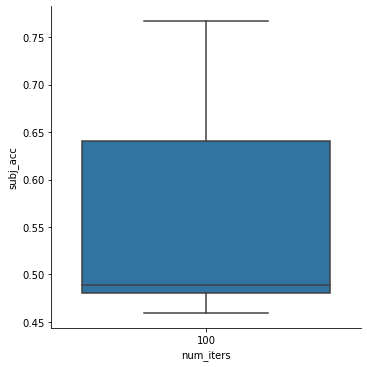

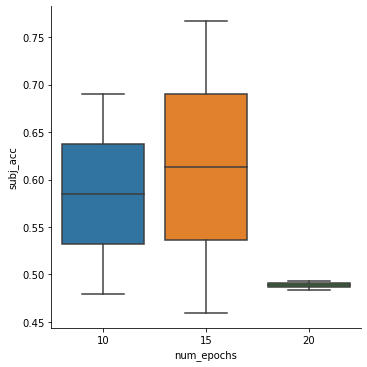

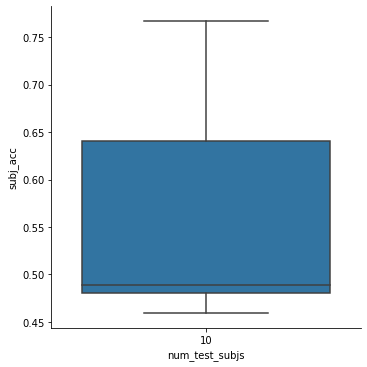

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(data = res_df, x = 'num_iters', y='subj_acc', kind='box')
plt.show()

sns.catplot(data = res_df, x = 'num_epochs', y='subj_acc', kind='box')
plt.show()

sns.catplot(data = res_df, x = 'num_test_subjs', y='subj_acc', kind='box')
plt.show()

In [38]:
d

[[100, 1, 0.481875, 0.43],
 [100, 5, 0.481875, 0.43],
 [100, 10, 0.481875, 0.43],
 [100, 15, 0.481875, 0.43],
 [100, 20, 0.481875, 0.43],
 [100, 1, 0.481875, 0.43],
 [100, 5, 0.481875, 0.43],
 [100, 10, 0.481875, 0.43],
 [100, 15, 0.481875, 0.43],
 [100, 20, 0.481875, 0.43],
 [100, 1, 0.481875, 0.43],
 [100, 5, 0.481875, 0.43],
 [100, 10, 0.481875, 0.43],
 [100, 15, 0.481875, 0.43],
 [100, 20, 0.481875, 0.43],
 [100, 1, 0.481875, 0.43],
 [100, 5, 0.481875, 0.43],
 [100, 10, 0.481875, 0.43],
 [100, 15, 0.481875, 0.43],
 [100, 20, 0.481875, 0.43],
 [100, 1, 0.481875, 0.43],
 [100, 5, 0.481875, 0.43],
 [100, 10, 0.481875, 0.43],
 [100, 15, 0.481875, 0.43],
 [100, 20, 0.481875, 0.43],
 [100, 1, 0.481875, 0.43],
 [100, 5, 0.481875, 0.43],
 [100, 10, 0.481875, 0.43],
 [100, 15, 0.481875, 0.43],
 [100, 20, 0.481875, 0.43]]

In [21]:
print(f"{n_test_subjs} subjects : ")
print(np.mean([res_dict[i]['eval'] for i in range(num_iters)]))
print(np.mean([res_dict[i]['subj_level_acc'] for i in range(num_iters)]))

8 subjects : 
0.44244791666666666
0.4166666666666667


In [14]:
print(f"{n_test_subjs} subjects : ")
print(np.mean([res_dict[i]['eval'] for i in range(num_iters)]))
print(np.mean([res_dict[i]['subj_level_acc'] for i in range(num_iters)]))

15 subjects : 
0.44736111362775166
0.4444444444444444


In [15]:
print(f"{n_test_subjs} subjects : ")
print(np.mean([res_dict[i]['eval'] for i in range(num_iters)]))
print(np.mean([res_dict[i]['subj_level_acc'] for i in range(num_iters)]))

15 subjects : 
0.44736111362775166
0.4444444444444444


In [16]:
print(np.mean([res_dict[i]['eval'] for i in range(num_iters)]))
print(np.mean([res_dict[i]['subj_level_acc'] for i in range(num_iters)]))

0.44736111362775166
0.4444444444444444


In [17]:
accs = [res_dict[i]['subj_level_acc'] for i in range(num_iters)]
np.mean(accs)

0.4444444444444444

<AxesSubplot:>

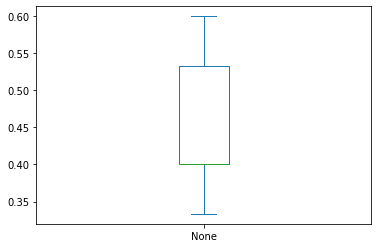

In [18]:
pd.Series(accs).plot.box()

In [19]:
my_list = res_dict[0]["test_pred"]
n=32
c = [my_list[i * n:(i + 1) * n] for i in range((len(my_list) + n - 1) // n )]
# pd.DataFrame(c).mean(axis=1)
c

[[0.5070113,
  0.16465992,
  0.48122215,
  0.4486994,
  0.39266095,
  0.45569283,
  0.453677,
  0.51846486,
  0.4452508,
  0.39522156,
  0.39622372,
  0.31888562,
  0.51943463,
  0.4699189,
  0.5236134,
  0.3891532,
  0.46924448,
  0.4759156,
  0.4244978,
  0.46768498,
  0.3690222,
  0.52378327,
  0.29376075,
  0.48122215,
  0.44827297,
  0.45631793,
  0.44238904,
  0.39716274,
  0.50464594,
  0.50514555,
  0.4544356,
  0.39651972],
 [0.29022944,
  0.4834538,
  0.45982715,
  0.41394088,
  0.3710991,
  0.3714983,
  0.42909554,
  0.44294304,
  0.43772668,
  0.43834448,
  0.38749528,
  0.39391112,
  0.42815793,
  0.25977758,
  0.45978463,
  0.34069023,
  0.3845086,
  0.43672225,
  0.3992129,
  0.4446404,
  0.45459804,
  0.38521647,
  0.4246188,
  0.3567533,
  0.40212372,
  0.4191378,
  0.3984646,
  0.4484913,
  0.454309,
  0.32566705,
  0.40597767,
  0.46851805],
 [0.2826801,
  0.30107045,
  0.403914,
  0.35224962,
  0.41288137,
  0.46687198,
  0.2266157,
  0.3381206,
  0.35454595,
  0.33

In [ ]:
res_dict[0]

In [ ]:
d = res_dict[0]
d
# [my_list[i * n:(i + 1) * n] for i in range((len(my_list) + n - 1) // n )]

In [ ]:
res_dict[0]